# IV Surface Generation Pipeline
## Arbitrage-Free IV Surfaces using Conditional VAE

This notebook orchestrates the complete pipeline for generating arbitrage-free volatility surfaces:

1. **Single Heston Calibration** - Fits Heston model parameters for each day
2. **Conditional VAE Training** - Trains the conditional VAE with market conditioning
3. **IV Surface Generation** - Generates surfaces for specific dates

---

**Status:** Ready to run (all dependencies installed, data prepared)
**Data Range:** 2019-01-01 to 2025-11-10
**Latest GDELT Data:** 2025-11-10 

---

###  File Operations Summary

**Read-Only Operations (Safe):**
-  Section 4 & 5: IV Surface Generation & Visualization - Only reads from existing models/data
-  Section 8: Results Management - Only reads and displays results

**Write Operations (Modifies Original Files):**
-  **Section 2**: Heston Calibration writes to `calibration_single_heston/`
  - Skip this section to use existing calibration results
-  **Section 3**: CVAE Training writes to `condtional_vae/best_model/`
  - Keep `RUN_CVAE_TRAINING = False` to use existing pre-trained model

**Notebook Output Location:**
-  All notebook-generated results are saved to `demo_results/` folder
-  Original data files and models remain unchanged (unless you run Sections 2 or 3)

**Recommendation:** For a demo run, skip Sections 2 & 3 and only run Sections 4-5 to generate surfaces using existing models.

##  Quick Start Guide for TAs/Reviewers

### Prerequisites Check

Before running this notebook, ensure:

1. **Python Environment**: Virtual environment with all dependencies installed
   ```bash
   source .venv/bin/activate  # Activate the virtual environment
   ```

2. **Required Files** (should already exist in project):
   -  `nifty_filtered_surfaces.pickle` - Input IV surface data
   -  `calibration_single_heston/NIFTY_heston_single_params_tensor.pt` - Pre-computed Heston parameters
   -  `llm_options_assistant/best_model_2025/cvae_model.pt` - Pre-trained CVAE model
   -  `api.json` - Gemini API key for LLM assistant

3. **Dependencies**: All packages from `requirements.txt` should be installed

### Recommended Demo Workflow (5-10 minutes)

**For a quick demo without re-training:**

1. **Run Section 1**: Setup and Environment 
2. **Skip Section 2**: Uses existing Heston calibration 
3. **Skip Section 3**: Uses pre-trained CVAE model 
4. **Run Section 4**: Generate IV surfaces for a date (takes ~1 minute) 
5. **Run Section 5**: View results and visualizations 
6. **Optional - Run Section 7**: Chat with LLM assistant (requires API key)

**Output Location**: All results saved to `demo_results/` folder

### Full Pipeline (if time permits - 30+ minutes)

Run all sections sequentially to see the complete training pipeline:
- Section 2: Heston Calibration (~10-30 minutes)
- Section 3: CVAE Training (~10-30 minutes)
- Sections 4-5: Surface Generation & Visualization

### Troubleshooting

**Issue**: Module not found errors
- **Solution**: Ensure virtual environment is activated

**Issue**: File not found errors
- **Solution**: Check that you're in the project root directory

**Issue**: LLM Assistant not working
- **Solution**: API key in `api.json` is optional for demo. Skip Section 7 if not needed.

### What This Notebook Demonstrates

1. **Heston Model Calibration**: Fits stochastic volatility model to market data
2. **Conditional VAE**: Learns distribution of Heston parameters conditioned on market variables
3. **IV Surface Generation**: Generates arbitrage-free volatility surfaces for any date
4. **AI Analysis**: Interactive LLM assistant for options analysis (optional)

---

## 🔧 USER CONFIGURATION - PIPELINE CONTROL

**IMPORTANT: Configure your pipeline settings below before running any sections!**

This cell controls which parts of the pipeline will execute:
- **Heston Calibration**: Fits model parameters (10-30 minutes)
- **CVAE Training**: Trains the conditional VAE (10-30 minutes) 
- **Surface Generation**: Generates IV surfaces (1-2 minutes)
- **Batch Generation**: Generates surfaces for multiple dates

**Instructions:**
1. **Review the settings below**
2. **Change `False` to `True` for components you want to run**
3. **Customize dates, sample counts, etc.**
4. **Run this configuration cell**
5. **Then run the pipeline sections below**

In [ ]:
# ============================================================================
# USER CONFIGURATION - PIPELINE CONTROL
# ============================================================================
# Set these variables to control which parts of the pipeline to run
# Change from False to True to enable each component

# HESTON CALIBRATION CONTROL
RUN_HESTON_CALIBRATION = False  # Set to True to run parameter calibration (8-9 Hours)

# CVAE TRAINING CONTROL  
RUN_CVAE_TRAINING = False       # Set to True to train the CVAE model (10-30 minutes)

# SURFACE GENERATION CONTROL
RUN_SURFACE_GENERATION = True   # Set to True to generate IV surfaces (1-2 minutes)

# BATCH GENERATION CONTROL
RUN_BATCH_GENERATION = False    # Set to True to generate surfaces for multiple dates

# ============================================================================
# ADVANCED CONFIGURATION
# ============================================================================

# Surface Generation Settings
TARGET_DATE = "2025-11-10"      # Date for surface generation (YYYY-MM-DD)
N_SAMPLES = 100                 # Number of surface samples to generate

# Batch Generation Settings (if RUN_BATCH_GENERATION = True)
BATCH_START_DATE = "2025-10-01" # Start date for batch generation
BATCH_END_DATE = "2025-11-10"   # End date for batch generation
BATCH_SAMPLES = 50              # Samples per date (fewer for speed)

# Model Preferences (automatic selection if not specified)
PREFER_PRETRAINED_MODEL = True  # Use pre-trained model if available
FORCE_RETRAIN = False           # Force retraining even if model exists

# Output Settings
SAVE_TO_DEMO_RESULTS = True     # Save all outputs to demo_results/ folder
KEEP_INTERMEDIATE_FILES = False # Keep temporary files after copying to demo_results

print("=" * 80)
print("PIPELINE CONFIGURATION")
print("=" * 80)
print(f"🔧 Heston Calibration:     {'ENABLED' if RUN_HESTON_CALIBRATION else 'DISABLED'}")
print(f"🧠 CVAE Training:          {'ENABLED' if RUN_CVAE_TRAINING else 'DISABLED'}")
print(f"📊 Surface Generation:     {'ENABLED' if RUN_SURFACE_GENERATION else 'DISABLED'}")
print(f"📈 Batch Generation:       {'ENABLED' if RUN_BATCH_GENERATION else 'DISABLED'}")
print()
print("GENERATION SETTINGS:")
print(f"📅 Target Date:            {TARGET_DATE}")
print(f"🔢 Samples per Surface:    {N_SAMPLES}")
if RUN_BATCH_GENERATION:
    print(f"📅 Batch Date Range:       {BATCH_START_DATE} to {BATCH_END_DATE}")
    print(f"🔢 Batch Samples:          {BATCH_SAMPLES}")
print()
print("MODEL SETTINGS:")
print(f"🎯 Prefer Pre-trained:     {'YES' if PREFER_PRETRAINED_MODEL else 'NO'}")
print(f"🔄 Force Retrain:          {'YES' if FORCE_RETRAIN else 'NO'}")
print()
print("OUTPUT SETTINGS:")
print(f"💾 Save to demo_results:   {'YES' if SAVE_TO_DEMO_RESULTS else 'NO'}")
print(f"🗂️  Keep Temp Files:        {'YES' if KEEP_INTERMEDIATE_FILES else 'NO'}")
print("=" * 80)
print()
print("📝 TO MODIFY SETTINGS:")
print("   1. Edit the variables above (change False to True)")
print("   2. Customize dates, sample counts, etc.")
print("   3. Re-run this cell")
print("   4. Then run the pipeline sections below")
print("=" * 80)

PIPELINE CONFIGURATION
🔧 Heston Calibration:     ENABLED
🧠 CVAE Training:          DISABLED
📊 Surface Generation:     ENABLED
📈 Batch Generation:       DISABLED

GENERATION SETTINGS:
📅 Target Date:            2025-11-10
🔢 Samples per Surface:    100

MODEL SETTINGS:
🎯 Prefer Pre-trained:     YES
🔄 Force Retrain:          NO

OUTPUT SETTINGS:
💾 Save to demo_results:   YES
🗂️  Keep Temp Files:        NO

📝 TO MODIFY SETTINGS:
   1. Edit the variables above (change False to True)
   2. Customize dates, sample counts, etc.
   3. Re-run this cell
   4. Then run the pipeline sections below


## Section 1: Setup and Environment

In [15]:
import subprocess
import sys
import os
from pathlib import Path
import json
from datetime import datetime
import shutil

print("=" * 80)
print("INITIALIZING PIPELINE")
print("=" * 80)
print("[1/3] Setting up paths...", end=" ")

# Get the project root directory using relative path
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "condtional_vae" else Path.cwd()
PROJECT_ROOT = PROJECT_ROOT.resolve()

# Create results folder if it doesn't exist - NOTEBOOK OUTPUTS ONLY
RESULTS_FOLDER = PROJECT_ROOT / "demo_results"
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

print("")
print("[2/3] Changing to project root...", end=" ")
os.chdir(PROJECT_ROOT)
print("")

print("[3/3] Gathering environment info...", end=" ")
print("\n")

# Use current Python executable (works in any environment)
PYTHON_EXECUTABLE = sys.executable

print("=" * 80)
print("IV SURFACE GENERATION PIPELINE")
print("=" * 80)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Results Folder: {RESULTS_FOLDER}")
print(f"Current Working Directory: {os.getcwd()}")
print(f"Python Executable: {PYTHON_EXECUTABLE}")
print(f"Python Version: {sys.version.split()[0]}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)
print(" Setup complete - ready to run scripts\n")
print("\n  IMPORTANT: This notebook only writes to demo_results/ folder")
print("   All original data files and models remain unchanged.")

INITIALIZING PIPELINE
[1/3] Setting up paths... 
[2/3] Changing to project root... 
[3/3] Gathering environment info... 

IV SURFACE GENERATION PIPELINE
Project Root: /Users/lavanyapareek/Desktop/Arbitrage Free IV Surfaces using VAE
Results Folder: /Users/lavanyapareek/Desktop/Arbitrage Free IV Surfaces using VAE/demo_results
Current Working Directory: /Users/lavanyapareek/Desktop/Arbitrage Free IV Surfaces using VAE
Python Executable: /Library/Developer/CommandLineTools/usr/bin/python3
Python Version: 3.9.6
Timestamp: 2025-11-12 16:15:07
 Setup complete - ready to run scripts


  IMPORTANT: This notebook only writes to demo_results/ folder
   All original data files and models remain unchanged.


In [16]:
print("[SETUP] Defining helper function...", end=" ")

def run_script(script_path, script_name, description, timeout=None):
    """
    Execute a Python script as subprocess and capture output.
    Also saves output to a log file in the results folder.
    
    Args:
        script_path: Full path to the Python script
        script_name: Display name for the script
        description: What the script does
        timeout: Timeout in seconds (None for no timeout)
    
    Returns:
        Tuple of (return_code, stdout, stderr)
    """
    print("\n" + "=" * 80)
    print(f"Running: {script_name}")
    print(f"Description: {description}")
    print(f"Script: {script_path}")
    print("=" * 80)
    
    if not os.path.exists(script_path):
        print(f" ERROR: Script not found at {script_path}")
        return -1, "", f"Script not found: {script_path}"
    
    # Create log file in results folder
    log_filename = f"{script_name.replace(' ', '_')}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
    log_file = RESULTS_FOLDER / log_filename
    
    try:
        # Use current Python executable (works in any environment)
        python_exec = PYTHON_EXECUTABLE
        
        # Set up environment with proper matplotlib backend for non-interactive use
        env = os.environ.copy()
        env['MPLBACKEND'] = 'Agg'  # Use Agg backend (non-interactive, works in subprocess)
        
        print("[1/4] Preparing environment...", end=" ")
        print("")
        
        print("[2/4] Starting subprocess...", end=" ")
        result = subprocess.run(
            [python_exec, script_path],
            capture_output=True,
            text=True,
            timeout=timeout,
            cwd=os.path.dirname(script_path),
            env=env  # Pass custom environment
        )
        print("")
        
        # Save output to log file
        print("[3/4] Saving execution log...", end=" ")
        with open(log_file, 'w') as f:
            f.write(f"Script: {script_name}\n")
            f.write(f"Description: {description}\n")
            f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("=" * 80 + "\n\n")
            if result.stdout:
                f.write("STDOUT:\n")
                f.write(result.stdout)
                f.write("\n\n")
            if result.stderr:
                f.write("STDERR:\n")
                f.write(result.stderr)
                f.write("\n\n")
            f.write(f"Return Code: {result.returncode}\n")
        print("")
        
        # Print output
        print("[4/4] Processing results...", end=" ")
        if result.stdout:
            print("")
            print(result.stdout)
        else:
            print("")
        
        if result.stderr:
            print("STDERR:", result.stderr)
        
        if result.returncode == 0:
            print(f"\n {script_name} completed successfully!")
            print(f" Log saved to: {log_file}")
        else:
            print(f"\n {script_name} exited with code {result.returncode}")
            print(f" Log saved to: {log_file}")
        
        return result.returncode, result.stdout, result.stderr
        
    except subprocess.TimeoutExpired:
        print(f" ERROR: {script_name} timed out after {timeout} seconds")
        return -1, "", f"Timeout after {timeout}s"
    except Exception as e:
        print(f" ERROR: {str(e)}")
        return -1, "", str(e)

print("\n")

[SETUP] Defining helper function... 



## Section 2: Single Heston Calibration

Fits a single Heston model per day across all strikes and maturities.

**Input:** `nifty_filtered_surfaces.pickle` (IV surfaces for NIFTY options)
**Output:** 
- `calibration_single_heston/NIFTY_heston_single_params.pickle` (parameters)
- `calibration_single_heston/NIFTY_heston_single_params_tensor.pt` (PyTorch tensor)

**Process:**
1. Stage 1: Fast calibration without Wasserstein penalty
2. Stage 2: Refinement with Wasserstein penalty
3. Validation: Feller condition, parameter bounds, arbitrage checks

** WARNING:** Running this cell will write calibration results to `calibration_single_heston/` folder.
If you want to preserve existing calibration results, skip this cell and use the existing files.

In [17]:
# HESTON CALIBRATION - CONTROLLED BY USER CONFIGURATION
# Uses the RUN_HESTON_CALIBRATION variable set in the configuration cell above

script_path = PROJECT_ROOT / "calibration_single_heston" / "run_single_heston_calibration.py"

# Check if calibration results already exist
output_pickle = PROJECT_ROOT / "calibration_single_heston" / "NIFTY_heston_single_params.pickle"
output_tensor = PROJECT_ROOT / "calibration_single_heston" / "NIFTY_heston_single_params_tensor.pt"
output_plot = PROJECT_ROOT / "calibration_single_heston" / "heston_single_calibration_errors.png"

# Decision logic based on user configuration and existing files
should_run_calibration = False

if RUN_HESTON_CALIBRATION:
    if FORCE_RETRAIN:
        should_run_calibration = True
        print("\n" + "=" * 80)
        print("HESTON CALIBRATION - FORCE RETRAIN ENABLED")
        print("=" * 80)
        print("🔄 FORCE_RETRAIN = True: Running calibration even if results exist")
    elif output_pickle.exists() and output_tensor.exists():
        print("\n" + "=" * 80)
        print("HESTON CALIBRATION - EXISTING RESULTS FOUND")
        print("=" * 80)
        print("⚠️  Calibration results already exist:")
        print(f"   📄 {output_pickle.name}")
        print(f"   📄 {output_tensor.name}")
        print()
        print("OPTIONS:")
        print("   1. Keep existing results (recommended)")
        print("   2. Set FORCE_RETRAIN = True to overwrite")
        print("   3. Manually delete files to force re-calibration")
        print()
        user_choice = input("Continue with existing results? (y/n): ").lower().strip()
        if user_choice in ['n', 'no']:
            should_run_calibration = True
            print("🔄 User chose to re-run calibration")
        else:
            print("✅ Using existing calibration results")
    else:
        should_run_calibration = True
        print("\n" + "=" * 80)
        print("HESTON CALIBRATION - STARTING NEW CALIBRATION")
        print("=" * 80)
        print("📊 No existing results found, starting calibration...")
else:
    print("\n" + "=" * 80)
    print("HESTON CALIBRATION - DISABLED")
    print("=" * 80)
    print("⏸️  RUN_HESTON_CALIBRATION = False")
    
    if output_pickle.exists() and output_tensor.exists():
        print("✅ Using existing calibration results:")
        print(f"   📄 {output_pickle.name}")
        print(f"   📄 {output_tensor.name}")
        if output_plot.exists():
            print(f"   📊 {output_plot.name}")
    else:
        print("❌ No existing calibration results found!")
        print("   To run calibration:")
        print("   1. Set RUN_HESTON_CALIBRATION = True in configuration cell")
        print("   2. Re-run configuration cell and this cell")

# Execute calibration if needed
if should_run_calibration:
    if not script_path.exists():
        print(f"❌ ERROR: Script not found at {script_path}")
    else:
        # Use current Python executable
        python_exec = PYTHON_EXECUTABLE
        
        # Set up environment with proper matplotlib backend
        env = os.environ.copy()
        env['MPLBACKEND'] = 'Agg'
        
        # Create log file
        log_filename = f"Single_Heston_Calibration_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
        log_file = RESULTS_FOLDER / log_filename
        
        try:
            print("\n[1/3] Starting calibration process...")
            print("⏱️  Estimated time: 10-30 minutes depending on data size")
            print("[2/3] Running script with real-time output...\n")
            
            # Use Popen for real-time output streaming
            process = subprocess.Popen(
                [python_exec, str(script_path)],
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                text=True,
                bufsize=1,  # Line buffered
                cwd=str(script_path.parent),
                env=env
            )
            
            # Capture output for logging while displaying in real-time
            output_lines = []
            
            # Stream output line by line
            for line in process.stdout:
                print(line, end='')  # Print immediately (real-time)
                output_lines.append(line)
            
            # Wait for process to complete
            return_code = process.wait()
            
            print("\n[3/3] Saving execution log...", end=" ")
            
            # Save to log file
            with open(log_file, 'w') as f:
                f.write(f"Script: Single Heston Calibration\n")
                f.write(f"Description: Fits Heston model parameters for each day\n")
                f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Configuration: RUN_HESTON_CALIBRATION = {RUN_HESTON_CALIBRATION}\n")
                f.write(f"Force Retrain: {FORCE_RETRAIN}\n")
                f.write("=" * 80 + "\n\n")
                f.write("OUTPUT:\n")
                f.write(''.join(output_lines))
                f.write(f"\n\nReturn Code: {return_code}\n")
            
            print("✅")
            
            # Check if successful
            if return_code == 0:
                print("\n🎉 Heston calibration completed successfully!")
                print(f"📋 Log saved to: {log_file}")
                
                # Check output files
                print("\n📁 Output files:")
                files_created = []
                if output_pickle.exists():
                    size_mb = output_pickle.stat().st_size / (1024 * 1024)
                    print(f"   ✅ {output_pickle.name} ({size_mb:.1f} MB)")
                    files_created.append(output_pickle.name)
                if output_tensor.exists():
                    size_mb = output_tensor.stat().st_size / (1024 * 1024)
                    print(f"   ✅ {output_tensor.name} ({size_mb:.1f} MB)")
                    files_created.append(output_tensor.name)
                if output_plot.exists():
                    size_kb = output_plot.stat().st_size / 1024
                    print(f"   ✅ {output_plot.name} ({size_kb:.1f} KB)")
                    files_created.append(output_plot.name)
                
                print(f"\n📊 Ready for CVAE training with {len(files_created)} output files")
            else:
                print(f"\n❌ Heston calibration failed with return code {return_code}")
                print(f"📋 Check log for details: {log_file}")
                
        except Exception as e:
            print(f"❌ ERROR: {str(e)}")

print("\n" + "=" * 80)


HESTON CALIBRATION - EXISTING RESULTS FOUND
⚠️  Calibration results already exist:
   📄 NIFTY_heston_single_params.pickle
   📄 NIFTY_heston_single_params_tensor.pt

OPTIONS:
   1. Keep existing results (recommended)
   2. Set FORCE_RETRAIN = True to overwrite
   3. Manually delete files to force re-calibration

✅ Using existing calibration results



## Section 3: Conditional VAE Training (Optional)

Trains the Conditional VAE with market conditioning variables.

**Input:** 
- `calibration_single_heston/NIFTY_heston_single_params_tensor.pt` (Heston parameters)
- Market data: India VIX, USD/INR, Crude Oil, US 10Y Yield
- GDELT unrest index

**Output:**
- `condtional_vae/best_model/` (trained model weights)
- Training curves, loss plots

**Note:** This is optional - a pre-trained model is available at `llm_options_assistant/best_model_2025/`

** WARNING:** Running training will write model files to `condtional_vae/best_model/` folder.
If you want to preserve existing trained models, keep `RUN_CVAE_TRAINING = False`.

In [5]:
# CVAE TRAINING - CONTROLLED BY USER CONFIGURATION
# Uses the RUN_CVAE_TRAINING variable set in the configuration cell above

# Check if Heston calibration parameters exist (required for training)
heston_tensor = PROJECT_ROOT / "calibration_single_heston" / "NIFTY_heston_single_params_tensor.pt"

# Check for existing trained models
pretrained_model = PROJECT_ROOT / "llm_options_assistant" / "best_model_2025" / "cvae_model.pt"
trained_model = PROJECT_ROOT / "condtional_vae" / "best_model" / "cvae_model.pt"

# Decision logic based on user configuration and existing files
should_run_training = False

if RUN_CVAE_TRAINING:
    # First check if Heston parameters exist
    if not heston_tensor.exists():
        print("\n" + "=" * 80)
        print("CVAE TRAINING - MISSING PREREQUISITES")
        print("=" * 80)
        print("❌ Heston calibration parameters not found!")
        print(f"   Required file: {heston_tensor.name}")
        print()
        print("📋 CVAE training requires Heston parameters as input.")
        print()
        print("🔧 TO FIX:")
        print("   1. Set RUN_HESTON_CALIBRATION = True in configuration")
        print("   2. Re-run configuration cell and Heston calibration section")
        print("   3. Then return to this CVAE training section")
        print("=" * 80)
    else:
        # Heston parameters exist, check training logic
        if FORCE_RETRAIN:
            should_run_training = True
            print("\n" + "=" * 80)
            print("CVAE TRAINING - FORCE RETRAIN ENABLED")
            print("=" * 80)
            print("🔄 FORCE_RETRAIN = True: Training new model even if one exists")
        elif trained_model.exists() or pretrained_model.exists():
            print("\n" + "=" * 80)
            print("CVAE TRAINING - EXISTING MODEL FOUND")
            print("=" * 80)
            print("⚠️  Trained model already exists:")
            if pretrained_model.exists():
                size_mb = pretrained_model.stat().st_size / (1024 * 1024)
                print(f"   🎯 Pre-trained: {pretrained_model.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
            if trained_model.exists():
                size_mb = trained_model.stat().st_size / (1024 * 1024)
                print(f"   🧠 User-trained: {trained_model.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
            print()
            print("OPTIONS:")
            print("   1. Keep existing model (recommended)")
            print("   2. Set FORCE_RETRAIN = True to overwrite")
            print("   3. Manually delete model files to force re-training")
            print()
            user_choice = input("Continue with existing model? (y/n): ").lower().strip()
            if user_choice in ['n', 'no']:
                should_run_training = True
                print("🔄 User chose to re-train model")
            else:
                print("✅ Using existing trained model")
        else:
            should_run_training = True
            print("\n" + "=" * 80)
            print("CVAE TRAINING - STARTING NEW TRAINING")
            print("=" * 80)
            print("🧠 No existing model found, starting training...")
            print(f"✅ Heston parameters available: {heston_tensor.name}")
else:
    print("\n" + "=" * 80)
    print("CVAE TRAINING - DISABLED")
    print("=" * 80)
    print("⏸️  RUN_CVAE_TRAINING = False")
    
    # Check what models are available
    available_models = []
    if pretrained_model.exists():
        size_mb = pretrained_model.stat().st_size / (1024 * 1024)
        available_models.append(f"🎯 Pre-trained: {pretrained_model.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
    if trained_model.exists():
        size_mb = trained_model.stat().st_size / (1024 * 1024)
        available_models.append(f"🧠 User-trained: {trained_model.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
    
    if available_models:
        print("✅ Available models for surface generation:")
        for model in available_models:
            print(f"   {model}")
    else:
        print("❌ No trained models found!")
        print("   To train a model:")
        print("   1. Ensure Heston calibration is complete")
        print("   2. Set RUN_CVAE_TRAINING = True in configuration")
        print("   3. Re-run configuration cell and this cell")
    
    if heston_tensor.exists():
        print(f"✅ Heston parameters ready: {heston_tensor.name}")
    else:
        print(f"❌ Heston parameters missing: {heston_tensor.name}")
        print("   Run Heston calibration first")

# Execute training if needed
if should_run_training:
    script_path = PROJECT_ROOT / "condtional_vae" / "train_cvae.py"
    
    if not script_path.exists():
        print(f"❌ ERROR: Training script not found at {script_path}")
    else:
        print(f"✅ Heston parameters found: {heston_tensor.name}")
        print("⏱️  Estimated training time: 10-30 minutes")
        print("🧠 Starting CVAE training with market conditioning variables...")
        
        return_code, stdout, stderr = run_script(
            script_path=str(script_path),
            script_name="Conditional VAE Training",
            description="Trains the conditional VAE with market conditioning variables",
            timeout=None
        )
        
        if return_code == 0:
            print("\n🎉 CVAE training completed successfully!")
            
            # Check output files
            model_dir = PROJECT_ROOT / "condtional_vae" / "best_model"
            model_file = model_dir / "cvae_model.pt"
            config_file = model_dir / "config.json"
            
            print("\n📁 Training outputs:")
            if model_file.exists():
                size_mb = model_file.stat().st_size / (1024 * 1024)
                print(f"   ✅ Model: {model_file.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
            if config_file.exists():
                size_kb = config_file.stat().st_size / 1024
                print(f"   ✅ Config: {config_file.relative_to(PROJECT_ROOT)} ({size_kb:.1f} KB)")
            
            # Check for training plots
            plots_dir = PROJECT_ROOT / "condtional_vae"
            plot_files = list(plots_dir.glob("*training*.png"))
            if plot_files:
                print("   📊 Training plots:")
                for plot in plot_files:
                    size_kb = plot.stat().st_size / 1024
                    print(f"      📈 {plot.name} ({size_kb:.1f} KB)")
            
            print(f"\n📊 Model ready for IV surface generation!")
        else:
            print(f"\n❌ CVAE training failed with return code {return_code}")
            print("📋 Check the execution log for details")

print("\n" + "=" * 80)


CVAE TRAINING - DISABLED
⏸️  RUN_CVAE_TRAINING = False
✅ Available models for surface generation:
   🎯 Pre-trained: llm_options_assistant/best_model_2025/cvae_model.pt (0.4 MB)
✅ Heston parameters ready: NIFTY_heston_single_params_tensor.pt



## Section 4: Generate IV Surfaces

Generates IV surfaces for specific dates using the trained CVAE model.

**Inputs:**
- Date (format: YYYY-MM-DD)
- Number of samples to generate (default: 100)
- Pre-trained CVAE model
- Market data: NIFTY spot, India VIX, USD/INR, Crude Oil, US 10Y Yield, GDELT unrest

**Outputs:**
- IV surface matrices (CSV)
- Surface visualization plots (PNG)
- PyTorch tensor data

**Usage:**
Define a date below, then run the cell to generate surfaces for that date.

In [6]:
# SURFACE GENERATION CONFIGURATION - CONTROLLED BY USER SETTINGS
# Uses variables set in the configuration cell above

print("=" * 80)
print("IV SURFACE GENERATION CONFIGURATION")
print("=" * 80)
print(f"📊 Surface Generation:     {'ENABLED' if RUN_SURFACE_GENERATION else 'DISABLED'}")
print(f"📅 Target Date:            {TARGET_DATE}")
print(f"🔢 Number of Samples:      {N_SAMPLES}")

# Check for available models
pretrained_model = PROJECT_ROOT / "llm_options_assistant" / "best_model_2025" / "cvae_model.pt"
trained_model = PROJECT_ROOT / "condtional_vae" / "best_model" / "cvae_model.pt"

MODEL_PATH = None
model_source = None

# Model selection logic based on user preferences
if PREFER_PRETRAINED_MODEL and pretrained_model.exists():
    MODEL_PATH = pretrained_model
    model_source = "pre-trained"
    size_mb = MODEL_PATH.stat().st_size / (1024 * 1024)
    print(f"🎯 Using Pre-trained Model: {MODEL_PATH.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
elif trained_model.exists():
    MODEL_PATH = trained_model
    model_source = "user-trained"
    size_mb = MODEL_PATH.stat().st_size / (1024 * 1024)
    print(f"🧠 Using User-trained Model: {MODEL_PATH.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
elif pretrained_model.exists():
    MODEL_PATH = pretrained_model
    model_source = "pre-trained (fallback)"
    size_mb = MODEL_PATH.stat().st_size / (1024 * 1024)
    print(f"🎯 Using Pre-trained Model (fallback): {MODEL_PATH.relative_to(PROJECT_ROOT)} ({size_mb:.1f} MB)")
else:
    print(f"❌ No trained model found!")
    print(f"   Expected locations:")
    print(f"     🎯 Pre-trained: {pretrained_model.relative_to(PROJECT_ROOT)}")
    print(f"     🧠 User-trained: {trained_model.relative_to(PROJECT_ROOT)}")

print(f"📊 Available Date Range:   2015-01-01 to 2025-11-10")
print(f"💾 Save to demo_results:   {'YES' if SAVE_TO_DEMO_RESULTS else 'NO'}")
print("=" * 80)

IV SURFACE GENERATION CONFIGURATION
📊 Surface Generation:     ENABLED
📅 Target Date:            2025-11-10
🔢 Number of Samples:      100
🎯 Using Pre-trained Model: llm_options_assistant/best_model_2025/cvae_model.pt (0.4 MB)
📊 Available Date Range:   2015-01-01 to 2025-11-10
💾 Save to demo_results:   YES


In [7]:
# EXECUTE SURFACE GENERATION - CONTROLLED BY USER CONFIGURATION
# Uses RUN_SURFACE_GENERATION variable from configuration cell

if not RUN_SURFACE_GENERATION:
    print("\n" + "=" * 80)
    print("IV SURFACE GENERATION - DISABLED")
    print("=" * 80)
    print("⏸️  RUN_SURFACE_GENERATION = False")
    print()
    print("🔧 TO ENABLE:")
    print("   1. Set RUN_SURFACE_GENERATION = True in configuration cell")
    print("   2. Optionally customize TARGET_DATE and N_SAMPLES")
    print("   3. Re-run configuration cell and this cell")
    print("=" * 80)
elif MODEL_PATH is None:
    print("\n" + "=" * 80)
    print("IV SURFACE GENERATION - NO MODEL AVAILABLE")
    print("=" * 80)
    print("❌ Cannot generate surfaces without a trained model!")
    print()
    print("🔧 TO FIX:")
    print("   1. Run CVAE training (set RUN_CVAE_TRAINING = True)")
    print("   2. Or ensure pre-trained model exists at:")
    print(f"      {pretrained_model.relative_to(PROJECT_ROOT)}")
    print("=" * 80)
else:
    # Execute surface generation
    script_path = PROJECT_ROOT / "condtional_vae" / "generate_iv_surface_by_date.py"
    
    # Use current Python executable
    python_exec = PYTHON_EXECUTABLE

    cmd = [
        python_exec,
        str(script_path),
        "--date", TARGET_DATE,
        "--n_samples", str(N_SAMPLES),
        "--output_dir", "results_date"
    ]

    try:
        print("\n" + "=" * 80)
        print(f"RUNNING IV SURFACE GENERATION")
        print("=" * 80)
        print(f"📅 Date: {TARGET_DATE}")
        print(f"🔢 Samples: {N_SAMPLES}")
        print(f"🧠 Model: {model_source}")
        print(f"⏱️  Estimated time: 1-2 minutes")
        print("=" * 80)
        
        # Set up environment with proper matplotlib backend
        env = os.environ.copy()
        env['MPLBACKEND'] = 'Agg'  # Use Agg backend (non-interactive, works in subprocess)
        
        print("\n[1/4] Starting surface generation...")
        
        result = subprocess.run(
            cmd,
            capture_output=True,
            text=True,
            timeout=300,
            cwd=str(PROJECT_ROOT / "condtional_vae"),
            env=env  # Pass custom environment
        )
        
        print("[2/4] Processing generation output...")
        print(result.stdout)
        if result.stderr:
            print("STDERR:", result.stderr)
        
        if SAVE_TO_DEMO_RESULTS:
            print("[3/4] Copying results to demo_results...")
            # Create timestamped folder in demo_results
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            dated_results_dir = RESULTS_FOLDER / f"{TARGET_DATE}_{timestamp}"
            dated_results_dir.mkdir(parents=True, exist_ok=True)
            
            # Copy generated files from temporary location to demo_results folder
            source_dir = PROJECT_ROOT / "condtional_vae" / "results_date" / TARGET_DATE
            
            if source_dir.exists():
                files_copied = []
                total_size = 0
                
                # Copy all files from source to demo_results folder
                for file in source_dir.glob("*"):
                    if file.is_file():
                        dest_file = dated_results_dir / file.name
                        shutil.copy2(file, dest_file)
                        size_kb = file.stat().st_size / 1024
                        total_size += size_kb
                        files_copied.append((file.name, size_kb))
                        print(f"   ✅ {file.name} ({size_kb:.1f} KB)")
                
                # Save execution log
                log_file = dated_results_dir / f"execution_log_{timestamp}.log"
                with open(log_file, 'w') as f:
                    f.write(f"IV Surface Generation Report\n")
                    f.write(f"Date: {TARGET_DATE}\n")
                    f.write(f"Samples: {N_SAMPLES}\n")
                    f.write(f"Model: {model_source}\n")
                    f.write(f"Model Path: {MODEL_PATH}\n")
                    f.write(f"Executed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                    f.write(f"Configuration: RUN_SURFACE_GENERATION = {RUN_SURFACE_GENERATION}\n")
                    f.write("=" * 80 + "\n\n")
                    f.write("STDOUT:\n")
                    f.write(result.stdout)
                    f.write("\n\nSTDERR:\n")
                    f.write(result.stderr)
                    f.write(f"\n\nReturn Code: {result.returncode}\n")
                
                print(f"   📋 Execution log saved")
                print(f"\n📁 Results saved to: {dated_results_dir.name}")
                print(f"📊 Total files: {len(files_copied)}, Total size: {total_size:.1f} KB")
                
                # Clean up temporary files if requested
                if not KEEP_INTERMEDIATE_FILES:
                    print("[4/4] Cleaning up temporary files...")
                    try:
                        shutil.rmtree(source_dir)
                        print("   🗑️  Temporary files removed")
                    except Exception as e:
                        print(f"   ⚠️  Could not remove temporary files: {e}")
                else:
                    print("[4/4] Keeping temporary files as requested")
                    print(f"   📂 Temporary files kept at: {source_dir}")
                
            else:
                print(f"   ❌ Source results directory not found: {source_dir}")
        else:
            print("[3/4] Skipping copy to demo_results (SAVE_TO_DEMO_RESULTS = False)")
            source_dir = PROJECT_ROOT / "condtional_vae" / "results_date" / TARGET_DATE
            if source_dir.exists():
                print(f"   📂 Results available at: {source_dir}")
            print("[4/4] Complete")
        
        # Final status
        if result.returncode == 0:
            print(f"\n🎉 IV Surface generation completed successfully!")
            print(f"📊 Generated {N_SAMPLES} surfaces for {TARGET_DATE}")
            if SAVE_TO_DEMO_RESULTS:
                print(f"📁 Results in: demo_results/{TARGET_DATE}_{timestamp}/")
        else:
            print(f"\n⚠️  Generation completed with warnings (return code {result.returncode})")
            print("📋 Check the execution log for details")
            
    except subprocess.TimeoutExpired:
        print(f"❌ Generation timed out after 300 seconds")
    except Exception as e:
        print(f"❌ Error: {str(e)}")

print("\n" + "=" * 80)


RUNNING IV SURFACE GENERATION
📅 Date: 2025-11-10
🔢 Samples: 100
🧠 Model: pre-trained
⏱️  Estimated time: 1-2 minutes

[1/4] Starting surface generation...
[2/4] Processing generation output...
Error: pip install yfinance nsepy

[3/4] Copying results to demo_results...
   ✅ mean_surface_heatmap.png (145.1 KB)
   ✅ iv_surfaces.pt (70.6 KB)
   ✅ mean_iv_surface.csv (3.1 KB)
   ✅ atm_term_structure.png (168.7 KB)
   ✅ median_iv_surface.csv (3.1 KB)
   ✅ iv_smiles.png (377.0 KB)
   📋 Execution log saved

📁 Results saved to: 2025-11-10_20251112_161219
📊 Total files: 6, Total size: 767.7 KB
[4/4] Cleaning up temporary files...
   🗑️  Temporary files removed

⚠️  Generation completed with warnings (return code 1)
📋 Check the execution log for details



## Section 5: View Results & Visualization

Display the generated IV surfaces and analysis results.


SEARCHING FOR RESULTS FOR 2025-11-10

 Found results in demo_results: 2025-11-10_20251112_161219


RESULTS FOR 2025-11-10

Mean IV Surface (Implied Volatility %):
     -20.0%  -18.0%  -16.0%  -14.0%  -12.0%  -10.0%  -8.0%  -6.0%  -4.0%  \
1M      NaN     NaN     NaN     NaN   14.98   13.56  13.21  13.88  14.05   
2M      NaN     NaN   14.06   14.38   13.42   13.02  13.54  13.74  13.85   
3M    14.50   13.81   13.46   13.22   13.50   13.63  13.71  13.77  13.82   
6M    12.61   12.24   12.73   12.91   13.02   13.11  13.17  13.23  13.28   
9M    12.28   12.08   12.30   12.44   12.54   12.61  12.67  12.73  12.78   
12M   12.05   12.10   12.14   12.18   12.23   12.27  12.31  12.35  12.39   
18M   11.05   11.17   11.26   11.33   11.39   11.45  11.50  11.54  11.59   
24M   10.65   10.69   10.73   10.77   10.82   10.86  10.89  10.93  10.97   

     -2.0%  ...   2.0%   4.0%   6.0%   8.0%  10.0%  12.0%  14.0%  16.0%  \
1M   14.14  ...  14.26  14.30  14.34  14.38  14.42  14.46  14.50  14.54   
2

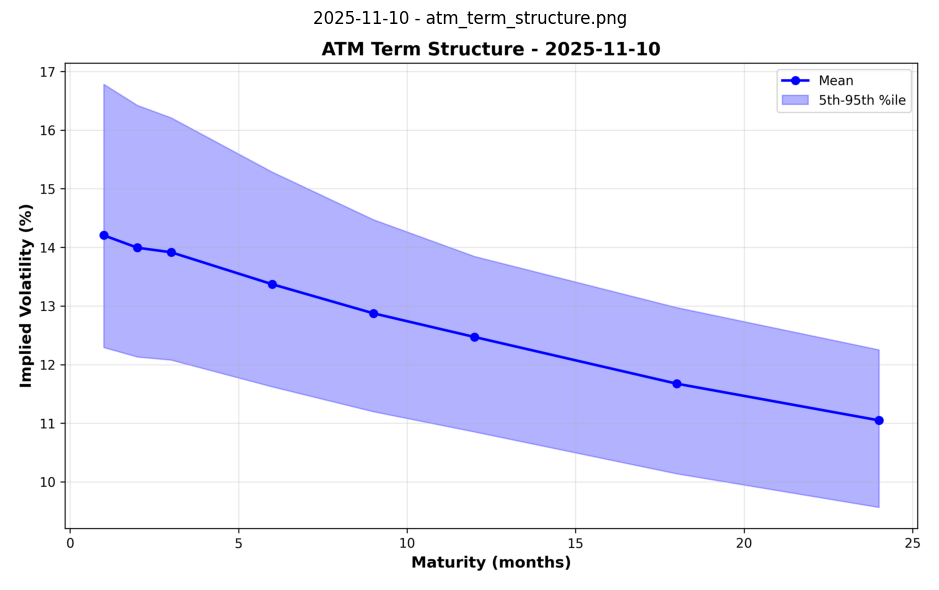


mean_surface_heatmap.png:


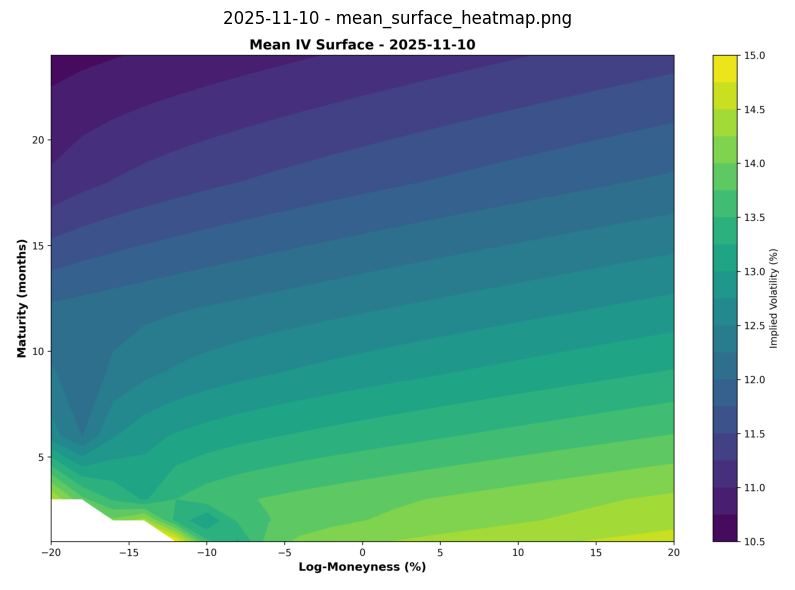


iv_smiles.png:


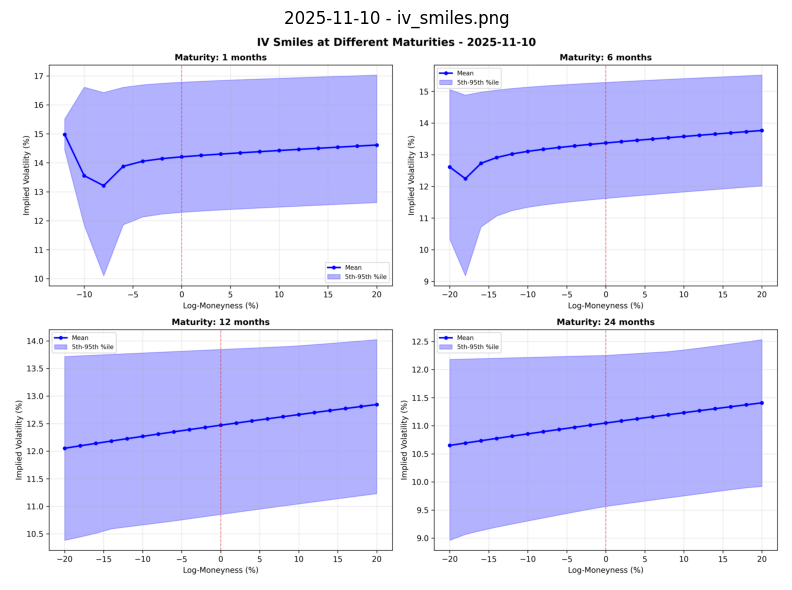


ALL FILES IN RESULTS DIRECTORY

  atm_term_structure.png                   (   168.7 KB)
  execution_log_20251112_161219.log        (     0.4 KB)
  iv_smiles.png                            (   377.0 KB)
  iv_surfaces.pt                           (    70.6 KB)
  mean_iv_surface.csv                      (     3.1 KB)
  mean_surface_heatmap.png                 (   145.1 KB)
  median_iv_surface.csv                    (     3.1 KB)


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Find the most recent results folder for the target date
print(f"\n{'=' * 80}")
print(f"SEARCHING FOR RESULTS FOR {TARGET_DATE}")
print(f"{'=' * 80}\n")

# Look for folders matching TARGET_DATE in demo_results folder
matching_dirs = sorted([d for d in RESULTS_FOLDER.glob(f"{TARGET_DATE}_*")], reverse=True)

# Fallback: Check if results exist in the original condtional_vae/results_date folder
fallback_dir = PROJECT_ROOT / "condtional_vae" / "results_date" / TARGET_DATE

if matching_dirs:
    results_dir = matching_dirs[0]  # Get the most recent
    print(f" Found results in demo_results: {results_dir.name}\n")
    source = "demo_results"
elif fallback_dir.exists():
    results_dir = fallback_dir
    print(f" Found results in original location: condtional_vae/results_date/{TARGET_DATE}\n")
    print(f" Note: These results were not generated from this notebook run.")
    print(f"  To save results to demo_results, run Section 4 (IV Surface Generation).\n")
    source = "original"
else:
    results_dir = None
    print(f" No results found for {TARGET_DATE}")
    print(f"\nSearched in:")
    print(f"  - {RESULTS_FOLDER}")
    print(f"  - {fallback_dir}")
    print("\nPlease run the IV Surface Generation cell (Section 4) first.")

if results_dir and results_dir.exists():
    print(f"\n{'=' * 80}")
    print(f"RESULTS FOR {TARGET_DATE}")
    print(f"{'=' * 80}\n")
    
    # Load and display mean IV surface
    mean_iv_file = results_dir / "mean_iv_surface.csv"
    if mean_iv_file.exists():
        df_mean = pd.read_csv(mean_iv_file, index_col=0)
        print("Mean IV Surface (Implied Volatility %):")
        print(df_mean.round(2))
        print()
    
    # Load and display median IV surface
    median_iv_file = results_dir / "median_iv_surface.csv"
    if median_iv_file.exists():
        df_median = pd.read_csv(median_iv_file, index_col=0)
        print("\nMedian IV Surface (Implied Volatility %):")
        print(df_median.round(2))
        print()
    
    # Display plots if they exist
    plot_files = [
        "atm_term_structure.png",
        "mean_surface_heatmap.png",
        "iv_smiles.png"
    ]
    
    print(f"\n{'=' * 80}")
    print("GENERATED VISUALIZATIONS")
    print(f"{'=' * 80}\n")
    
    for plot_file in plot_files:
        plot_path = results_dir / plot_file
        if plot_path.exists():
            print(f"\n{plot_file}:")
            img = Image.open(plot_path)
            plt.figure(figsize=(12, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{TARGET_DATE} - {plot_file}")
            plt.tight_layout()
            plt.show()
    
    # List all files in results directory
    print(f"\n{'=' * 80}")
    print("ALL FILES IN RESULTS DIRECTORY")
    print(f"{'=' * 80}\n")
    
    for file in sorted(results_dir.glob("*")):
        size = file.stat().st_size / 1024  # KB
        print(f"  {file.name:40s} ({size:8.1f} KB)")
    
    if source == "original":
        print(f"\n{'=' * 80}")
        print("NOTE: Using results from original location")
        print(f"{'=' * 80}")
        print(f"These results are from: condtional_vae/results_date/{TARGET_DATE}")
        print(f"To generate fresh results in demo_results, run Section 4.")

## Section 7: Interactive LLM Options Assistant

Chat with an AI-powered options analyst that can:
- Generate IV surfaces for any date
- Analyze volatility patterns and market sentiment
- Identify trading opportunities
- Provide actionable recommendations

**Requirements:**
- Google Gemini API key (free, no credit card required)
- Get your key at: https://aistudio.google.com/app/apikey

**Usage:**
1. Set your API key: `os.environ['GEMINI_API_KEY'] = 'your-key-here'`
2. Run the cell below to start chatting
3. Type 'quit' to exit the chat

In [9]:
# Load API key from api.json and run the LLM Options Assistant
import os
import json
import sys

# Load API key from api.json
api_file = PROJECT_ROOT / "api.json"

if api_file.exists():
    with open(api_file, 'r') as f:
        api_data = json.load(f)
        os.environ['GEMINI_API_KEY'] = api_data['API_KEY']
    print(" API key loaded from api.json\n")
else:
    print("=" * 80)
    print("  API KEY FILE NOT FOUND")
    print("=" * 80)
    print(f"\nExpected file: {api_file}")
    print("\nCreate api.json with:")
    print('{\n    "API_KEY": "your-gemini-api-key-here"\n}')
    print("\nGet your free API key at: https://aistudio.google.com/app/apikey")
    print("=" * 80)
    sys.exit(1)

# Add the llm_options_assistant directory to path
llm_assistant_dir = PROJECT_ROOT / "llm_options_assistant"
sys.path.insert(0, str(llm_assistant_dir))

# Import and run the assistant
print("=" * 80)
print(" Starting NIFTY 50 Options Analysis Assistant")
print("=" * 80)
print(f"Using script: {llm_assistant_dir / 'options_analyst_gemini.py'}")
print("=" * 80 + "\n")

# Import the main function from the script
from options_analyst_gemini import main

# Run the interactive assistant
main()

 API key loaded from api.json

 Starting NIFTY 50 Options Analysis Assistant
Using script: /Users/lavanyapareek/Desktop/Arbitrage Free IV Surfaces using VAE/llm_options_assistant/options_analyst_gemini.py

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


/Users/lavanyapareek/Library/Python/3.9/lib/python/site-packages/google/api_core/_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.6) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)
/Users/lavanyapareek/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



 NIFTY 50 OPTIONS ANALYSIS ASSISTANT (Powered by Google Gemini)

Initializing AI analyst...

Hello! I am an expert options analyst and quantitative researcher, specializing in NIFTY 50 options in India. My primary goal is to provide deep insights into volatility dynamics and actionable trading recommendations.

Here's what I can do for you:

1.  **Generate IV (Implied Volatility) Surfaces:** I can generate detailed IV surfaces for any requested date using a sophisticated, trained Conditional VAE model. This surface will cover 8 maturities (1M, 2M, 3M, 6M, 9M, 12M, 18M, 24M) across 21 log-moneyness strikes (from -20% to +20%).
2.  **Analyze Volatility Smiles, Term Structures, and Skew Patterns:** I will break down the shape of the volatility smile across different maturities and analyze the term structure of volatility, highlighting any specific patterns like contango or backwardation, and examine the skew.
3.  **Identify Trading Opportunities:** Based on the volatility patterns, I can

## Section 8: Advanced Usage - Batch Generation

Generate IV surfaces for multiple dates in a loop.

In [12]:
# BATCH SURFACE GENERATION - CONTROLLED BY USER CONFIGURATION
# Uses RUN_BATCH_GENERATION variable from configuration cell

if not RUN_BATCH_GENERATION:
    print("=" * 80)
    print("BATCH SURFACE GENERATION - DISABLED")
    print("=" * 80)
    print("⏸️  RUN_BATCH_GENERATION = False")
    print()
    print("🔧 TO ENABLE BATCH GENERATION:")
    print("   1. Set RUN_BATCH_GENERATION = True in configuration cell")
    print("   2. Customize BATCH_START_DATE and BATCH_END_DATE")
    print("   3. Adjust BATCH_SAMPLES (fewer samples = faster)")
    print("   4. Re-run configuration cell and this cell")
    print()
    print("📊 CURRENT BATCH SETTINGS:")
    print(f"   📅 Date Range: {BATCH_START_DATE} to {BATCH_END_DATE}")
    print(f"   🔢 Samples per Date: {BATCH_SAMPLES}")
    print(f"   💾 Save to demo_results: {'YES' if SAVE_TO_DEMO_RESULTS else 'NO'}")
    print("=" * 80)
else:
    # Check if model exists
    pretrained_model = PROJECT_ROOT / "llm_options_assistant" / "best_model_2025" / "cvae_model.pt"
    trained_model = PROJECT_ROOT / "condtional_vae" / "best_model" / "cvae_model.pt"
    
    if not (pretrained_model.exists() or trained_model.exists()):
        print("\n" + "=" * 80)
        print("BATCH GENERATION - NO MODEL AVAILABLE")
        print("=" * 80)
        print("❌ No trained model available for batch generation!")
        print()
        print("🔧 TO FIX:")
        print("   1. Ensure pre-trained model exists, OR")
        print("   2. Run CVAE training (set RUN_CVAE_TRAINING = True)")
        print("=" * 80)
    else:
        # Generate date range
        from datetime import datetime, timedelta
        
        try:
            start_date = datetime.strptime(BATCH_START_DATE, "%Y-%m-%d")
            end_date = datetime.strptime(BATCH_END_DATE, "%Y-%m-%d")
        except ValueError as e:
            print(f"❌ Invalid date format: {e}")
            print("   Use YYYY-MM-DD format (e.g., '2025-10-01')")
            start_date = end_date = None
        
        if start_date and end_date and start_date <= end_date:
            dates_to_generate = []
            current = start_date
            while current <= end_date:
                dates_to_generate.append(current.strftime("%Y-%m-%d"))
                current += timedelta(days=1)
            
            print("=" * 80)
            print("BATCH SURFACE GENERATION - STARTING")
            print("=" * 80)
            print(f"📅 Date Range: {BATCH_START_DATE} to {BATCH_END_DATE}")
            print(f"📊 Total Dates: {len(dates_to_generate)}")
            print(f"🔢 Samples per Date: {BATCH_SAMPLES}")
            print(f"⏱️  Estimated Time: {len(dates_to_generate) * 1.5:.1f} minutes")
            
            # Determine which model to use
            if PREFER_PRETRAINED_MODEL and pretrained_model.exists():
                model_path = pretrained_model
                model_name = "pre-trained"
            elif trained_model.exists():
                model_path = trained_model
                model_name = "user-trained"
            else:
                model_path = pretrained_model
                model_name = "pre-trained (fallback)"
            
            size_mb = model_path.stat().st_size / (1024 * 1024)
            print(f"🧠 Using Model: {model_name} ({size_mb:.1f} MB)")
            print(f"💾 Results will be saved to: {RESULTS_FOLDER}")
            print("=" * 80)
            
            # Execute batch generation
            python_exec = PYTHON_EXECUTABLE
            script_path = PROJECT_ROOT / "condtional_vae" / "generate_iv_surface_by_date.py"
            
            results = {}
            batch_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            
            # Set up environment with proper matplotlib backend
            env = os.environ.copy()
            env['MPLBACKEND'] = 'Agg'  # Use Agg backend for batch processing
            
            print(f"\n🚀 Starting batch generation...")
            
            for idx, date in enumerate(dates_to_generate, 1):
                print(f"\n[{idx:3d}/{len(dates_to_generate)}] {date}...", end=" ")
                
                cmd = [
                    str(python_exec),
                    str(script_path),
                    "--date", date,
                    "--n_samples", str(BATCH_SAMPLES),
                    "--output_dir", "results_date"
                ]
                
                try:
                    result = subprocess.run(
                        cmd,
                        capture_output=True,
                        text=True,
                        timeout=120,  # 2 minutes per date
                        cwd=str(PROJECT_ROOT / "condtional_vae"),
                        env=env
                    )
                    
                    if result.returncode == 0:
                        # Copy results to demo_results folder if enabled
                        if SAVE_TO_DEMO_RESULTS:
                            source_dir = PROJECT_ROOT / "condtional_vae" / "results_date" / date
                            dest_dir = RESULTS_FOLDER / f"batch_{batch_timestamp}" / date
                            
                            if source_dir.exists():
                                dest_dir.mkdir(parents=True, exist_ok=True)
                                files_copied = 0
                                for file in source_dir.glob("*"):
                                    if file.is_file():
                                        shutil.copy2(file, dest_dir / file.name)
                                        files_copied += 1
                                
                                # Clean up temporary files if requested
                                if not KEEP_INTERMEDIATE_FILES:
                                    shutil.rmtree(source_dir)
                                
                                print(f"✅ ({files_copied} files)")
                            else:
                                print("⚠️  No output")
                        else:
                            print("✅")
                        
                        results[date] = "Success"
                    else:
                        print(f"❌ (code {result.returncode})")
                        results[date] = f"Failed (code {result.returncode})"
                        
                except subprocess.TimeoutExpired:
                    print("⏱️  Timeout")
                    results[date] = "Timeout"
                except Exception as e:
                    print(f"❌ {str(e)[:30]}...")
                    results[date] = str(e)[:50]
            
            # Generate summary
            print(f"\n{'=' * 80}")
            print("BATCH GENERATION SUMMARY")
            print(f"{'=' * 80}")
            
            success_count = sum(1 for v in results.values() if v == "Success")
            failed_count = len(results) - success_count
            
            print(f"\n📊 RESULTS:")
            print(f"   ✅ Successful: {success_count}/{len(dates_to_generate)} ({success_count/len(dates_to_generate)*100:.1f}%)")
            print(f"   ❌ Failed: {failed_count}")
            
            if SAVE_TO_DEMO_RESULTS:
                batch_dir = RESULTS_FOLDER / f"batch_{batch_timestamp}"
                if batch_dir.exists():
                    total_dirs = len(list(batch_dir.glob("*")))
                    print(f"   📁 Results saved to: {batch_dir.name}/ ({total_dirs} date folders)")
            
            # Show detailed results
            print(f"\n📋 DETAILED RESULTS:")
            for date, status in results.items():
                symbol = "✅" if status == "Success" else "❌"
                print(f"   {symbol} {date}: {status}")
            
            # Save summary log
            if SAVE_TO_DEMO_RESULTS:
                summary_file = RESULTS_FOLDER / f"batch_summary_{batch_timestamp}.log"
                with open(summary_file, 'w') as f:
                    f.write(f"Batch Surface Generation Summary\n")
                    f.write(f"Date Range: {BATCH_START_DATE} to {BATCH_END_DATE}\n")
                    f.write(f"Samples per Date: {BATCH_SAMPLES}\n")
                    f.write(f"Model: {model_name}\n")
                    f.write(f"Executed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                    f.write(f"Success Rate: {success_count}/{len(dates_to_generate)} ({success_count/len(dates_to_generate)*100:.1f}%)\n")
                    f.write("=" * 80 + "\n\n")
                    for date, status in results.items():
                        f.write(f"{date}: {status}\n")
                
                print(f"   📋 Summary saved to: {summary_file.name}")
            
            print("=" * 80)
        else:
            print("❌ Invalid date range! Ensure BATCH_START_DATE <= BATCH_END_DATE")

print("\n" + "=" * 80)

BATCH SURFACE GENERATION - DISABLED
⏸️  RUN_BATCH_GENERATION = False

🔧 TO ENABLE BATCH GENERATION:
   1. Set RUN_BATCH_GENERATION = True in configuration cell
   2. Customize BATCH_START_DATE and BATCH_END_DATE
   3. Adjust BATCH_SAMPLES (fewer samples = faster)
   4. Re-run configuration cell and this cell

📊 CURRENT BATCH SETTINGS:
   📅 Date Range: 2025-10-01 to 2025-11-10
   🔢 Samples per Date: 50
   💾 Save to demo_results: YES



## Section 9: Pipeline Summary & Notes

### Project Overview

This notebook orchestrates the **Arbitrage-Free IV Surface Generation Pipeline**, which consists of three main components:

1. **Heston Model Calibration**
   - Fits single Heston parameters for each trading day
   - Uses two-stage optimization (fast + Wasserstein refinement)
   - Input: IV surfaces from NIFTY options market
   - Output: 5 parameters (kappa, theta, sigma_v, rho, v0) per day

2. **Conditional VAE Training** (Optional)
   - Trains a variational autoencoder with market conditioning
   - Conditions on: VIX, USD/INR, Oil prices, Interest rates, Geopolitical unrest
   - Learns latent distribution of Heston parameters
   - Pre-trained model available: `llm_options_assistant/best_model_2025/`

3. **IV Surface Generation**
   - Generates forward-looking IV surfaces for any date
   - Conditions on current market state
   - Produces 100 sample surfaces with statistics
   - Outputs: matrices, plots, PyTorch tensors

### Key Features

 **Current Data:** GDELT unrest index updated to 2025-11-10
 **Market Data:** India VIX, USD/INR, Crude Oil, US 10Y Yield (via yfinance)
 **Full Date Range:** 2015-01-01 to 2025-11-10
 **Pre-trained Model:** Ready for immediate IV surface generation
 **LLM Assistant:** Interactive AI analyst for options analysis
 **Error Handling:** Graceful fallbacks for missing data

### How to Use

1. **Run Heston Calibration:** Execute Section 2 (takes 10-30 minutes) - Optional if using existing
2. **Skip CVAE Training:** Use pre-trained model (Section 3)
3. **Generate Surfaces:** Set date in Section 4, run the cell
4. **View Results:** Section 5 displays matrices and plots
5. **Chat with AI:** Section 7 provides interactive options analysis
6. **Batch Generation:** Optional batch processing (Section 8)

### Typical Workflow

```
Setup (Section 1)
    ↓
Heston Calibration (Section 2) [Optional - uses existing]
    ↓
CVAE Training (Section 3) [Skip if using pre-trained]
    ↓
IV Surface Generation (Section 4) [Main output]
    ↓
Visualize Results (Section 5)
    ↓
Chat with LLM Assistant (Section 7) [Interactive analysis]
```

### File Structure

```
/project_root/
├── calibration_single_heston/
│   ├── run_single_heston_calibration.py
│   └── NIFTY_heston_single_params_tensor.pt (output)
├── condtional_vae/
│   ├── train_cvae.py
│   ├── generate_iv_surface_by_date.py
│   └── results_date/ (generated surfaces)
├── llm_options_assistant/
│   ├── best_model_2025/cvae_model.pt (pre-trained model)
│   └── options_analyst_gemini.py (LLM assistant)
├── demo_results/ (notebook outputs)
└── Scripts_Orchestration.ipynb (this notebook)
```

### Troubleshooting

**Issue:** "Module not found" errors
**Solution:** Ensure venv is activated. Run: `source .venv/bin/activate`

**Issue:** "File not found" in calibration
**Solution:** Check that `nifty_filtered_surfaces.pickle` exists in project root

**Issue:** No market data available
**Solution:** Ensure yfinance can reach internet. Check ticker symbols (^INDIAVIX, EURINR=X, etc.)

**Issue:** GDELT data not found
**Solution:** Run `condtional_vae/fetch_and_compute_unrest_index.py` to update

**Issue:** LLM Assistant not working
**Solution:** Get free Gemini API key from https://aistudio.google.com/app/apikey

### References

- Heston Model: Two-factor stochastic volatility model
- Conditional VAE: Learns conditional distribution of parameters given market state
- GDELT Data: Geopolitical event database for sentiment/unrest index
- Wasserstein Metric: Optimal transport distance for distribution matching
- Google Gemini: Free LLM API for options analysis

## Section 10: Results Management

View all generated results and organize them.

In [13]:
print(f"\n{'=' * 80}")
print("RESULTS FOLDER CONTENTS")
print(f"{'=' * 80}\n")

print(f"Results Location: {RESULTS_FOLDER}\n")

if RESULTS_FOLDER.exists():
    # Get all subdirectories
    subdirs = sorted([d for d in RESULTS_FOLDER.iterdir() if d.is_dir()], reverse=True)
    
    if subdirs:
        print(f"Found {len(subdirs)} result directories:\n")
        
        for subdir in subdirs:
            # Parse directory name
            parts = subdir.name.rsplit('_', 2)  # Split from right to get date and timestamp
            dir_name = subdir.name
            
            # Count files
            files = list(subdir.glob("*"))
            file_count = len(files)
            total_size = sum(f.stat().st_size for f in files if f.is_file()) / 1024 / 1024  # MB
            
            print(f" {dir_name}/")
            print(f"   Files: {file_count}, Size: {total_size:.2f} MB")
            
            # List files
            for file in sorted(files):
                size = file.stat().st_size / 1024
                print(f"     • {file.name:35s} ({size:8.1f} KB)")
            print()
    else:
        print("No results generated yet in demo_results folder.")
        print("\nRun the IV Surface Generation cell (Section 4) to create results.")
        
        # Check for results in original location
        original_results = PROJECT_ROOT / "condtional_vae" / "results_date"
        if original_results.exists():
            original_subdirs = list(original_results.glob("*"))
            if original_subdirs:
                print(f"\n Found {len(original_subdirs)} result(s) in original location:")
                print(f"  {original_results}")
                print("\nThese can be viewed in Section 5 (View Results) as fallback.")
else:
    print(f"Results folder not yet created: {RESULTS_FOLDER}")
    print("It will be created when you first run the IV Surface Generation.")

print(f"\n{'=' * 80}")
print("HOW TO USE RESULTS")
print(f"{'=' * 80}\n")
print(f"1. Results are saved in: {RESULTS_FOLDER}")
print(f"2. Each run creates a timestamped folder: DATE_YYYYMMDD_HHMMSS/")
print(f"3. Inside each folder:")
print(f"   • iv_surfaces.pt - PyTorch tensor with samples")
print(f"   • mean_iv_surface.csv - Average IV surface (8x21 matrix)")
print(f"   • median_iv_surface.csv - Median IV surface (8x21 matrix)")
print(f"   • atm_term_structure.png - Term structure plot")
print(f"   • mean_surface_heatmap.png - IV heatmap visualization")
print(f"   • iv_smiles.png - Volatility smile across maturities")
print(f"   • execution_log_*.log - Detailed execution log")
print(f"\n4. You can download/share any result folder directly")
print(f"\n5. Fallback: If no demo_results exist, Section 5 will use results from:")
print(f"   condtional_vae/results_date/ (if available)")


RESULTS FOLDER CONTENTS

Results Location: /Users/lavanyapareek/Desktop/Arbitrage Free IV Surfaces using VAE/demo_results

Found 1 result directories:

 2025-11-10_20251112_161219/
   Files: 7, Size: 0.75 MB
     • atm_term_structure.png              (   168.7 KB)
     • execution_log_20251112_161219.log   (     0.4 KB)
     • iv_smiles.png                       (   377.0 KB)
     • iv_surfaces.pt                      (    70.6 KB)
     • mean_iv_surface.csv                 (     3.1 KB)
     • mean_surface_heatmap.png            (   145.1 KB)
     • median_iv_surface.csv               (     3.1 KB)


HOW TO USE RESULTS

1. Results are saved in: /Users/lavanyapareek/Desktop/Arbitrage Free IV Surfaces using VAE/demo_results
2. Each run creates a timestamped folder: DATE_YYYYMMDD_HHMMSS/
3. Inside each folder:
   • iv_surfaces.pt - PyTorch tensor with samples
   • mean_iv_surface.csv - Average IV surface (8x21 matrix)
   • median_iv_surface.csv - Median IV surface (8x21 matrix)
   • atm